In [11]:
import pandas as pd
import numpy as np
import os
import sys
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any, Dict, List, Optional, Set, Union
import unicodedata

# Configure pandas to display all columns
pd.set_option('display.max_columns', None)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Add project root to sys.path
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.entities.lineup import Lineup, Player, Position

from src.db.nst_db_utils import *
from src.db.nhl_db_utils import get_player_full_name, insert_player_data
from src.data_processing.nst_scraper import *
from src.data_processing.pbp_utils import *
from src.data_processing.game_utils import *
from src.data_processing.team_utils import *
from src.data_processing.player_utils import *

In [12]:
# goalie_stats = get_goalie_stats(
#     start_date="2024-10-01",
#     end_date="2025-01-31",
#     table_name="goalie_stats_5v5"
# )
# goalie_stats

In [13]:
db_prefix = 'NHL_DB_'

def extract_team_goalies(team: str, reference_date: Optional[str] = None) -> Lineup:
    """
    Gets stats for goalies in the lineup, maintaining lineup order.
    
    Args:
        team (str): The three-letter team code (e.g., 'TOR').
        reference_date (Optional[str]): The reference date in 'YYYY-MM-DD' format. Defaults to yesterday's date.
    
    Returns:
        Lineup: A `Lineup` object containing the team's players from the most recent game.
    
    Raises:
        ValueError: If no recent game is found for the team or if the team is not part of the retrieved game.
    """
    # Step 1: Determine the reference date
    if reference_date is None:
        today_datetime = datetime.now()
        yesterday_datetime = today_datetime - timedelta(days=1, hours=6)  # Adjust for UTC offset if necessary
        reference_date = yesterday_datetime.strftime('%Y-%m-%d')

    # Step 2: Retrieve the most recent game ID for the team
    game_id, back_to_back = get_most_recent_game_id(team, reference_date)
    if game_id is None:
        raise ValueError(f"No recent game found for team '{team}' before {reference_date}.")

    # Print the game_id
    print(f"Game ID: {game_id}")

    # Step 3: Fetch the game boxscore data
    game_data = get_game_boxscore(game_id, clean=False)

    # Step 4: Process the boxscore to obtain skaters and goalies
    away_skaters, away_goalies, home_skaters, home_goalies = display_boxscore(game_data)

    # Extract team abbreviations to determine if the team is home or away
    away_team_code = game_data.get('awayTeam', {}).get('abbrev')
    home_team_code = game_data.get('homeTeam', {}).get('abbrev')

    if not away_team_code or not home_team_code:
        raise ValueError("Team abbreviations not found in game data.")

    if team.upper() == away_team_code.upper():
        team_side = 'Away'
        skaters = away_skaters
        goalies = away_goalies
    elif team.upper() == home_team_code.upper():
        team_side = 'Home'
        skaters = home_skaters
        goalies = home_goalies
    elif team.upper() == 'UTA':
        # Since UTA did not exist in the previous season, match with ARI
        if 'ARI' == away_team_code.upper():
            team_side = 'Away'
            skaters = away_skaters
            goalies = away_goalies
        elif 'ARI' == home_team_code.upper():
            team_side = 'Home'
            skaters = home_skaters
            goalies = home_goalies
        else:
            raise ValueError(f"Team '{team}' not found in game ID {game_id}.")
    else:
        raise ValueError(f"Team '{team}' not found in game ID {game_id}.")

    # Step 5: Construct the Lineup object
    lineup = Lineup(name=f"{team.upper()} Lineup from Game {game_id}")
    print(f"Back to back: {back_to_back}")
    lineup.back_to_back = back_to_back  # Assign back_to_back to the Lineup

    # Add Goalies to the Lineup
    for _, goalie in goalies.iterrows():
        player = Player(
            player_id=goalie['playerId'],
            name=get_player_full_name(goalie['playerId'], db_prefix, suppress_log=True),
            team=team.upper(),
            position=Position.G
        )
        try:
            empty_slot = next(i for i, p in enumerate(lineup.goalies) if p is None)
            lineup.set_goalie(player, empty_slot)
        except StopIteration:
            print(f"No available goalie slot to add player '{player.name}'.")

    return lineup
# col_lineup = extract_team_lineup('COL', '2024-12-10')

In [14]:
def get_pregame_matchup_stats(input_date: str, team: str, last_n: int=None, team_stats_df: pd.DataFrame=None) -> Dict[str, Any]:
    """
    Retrieves and compiles pre-game statistics for both teams in a matchup.
    
    This function performs the following steps:
    1. Calculates reference date and retrieves team statistics
    2. Identifies the matchup game and opponent team
    3. Compiles team-level statistics for both teams
    4. Identifies starting goalies for both teams
    
    Args:
        input_date (str): The game date in 'YYYY-MM-DD' format
        team (str): The three-letter team code (e.g., 'TOR')
        last_n (int, optional): Number of previous games to consider for team statistics
        team_stats_df (pd.DataFrame, optional): Pre-loaded team statistics DataFrame. If None, will fetch new data
    
    Returns:
        pd.DataFrame: A DataFrame with two rows (one per team) containing:
            - Game context (date, game_id, home/away)
            - Team statistics
            - Starting goalie information (name, team, id)
    """
    try:
        # Step 1a: Calculate the date minus one day
        reference_datetime = datetime.strptime(input_date, '%Y-%m-%d') - timedelta(days=1)
        reference_date_str = reference_datetime.strftime('%Y-%m-%d')
        print(f"Fetching data for reference date: {reference_date_str}")

        # Step 1b: If team_stats_df is not provided, fetch them
        if team_stats_df is None or team_stats_df.empty:
            team_stats_df = nst_team_on_ice_scraper(
                startdate='',
                enddate=reference_date_str,
                stype=2,
                sit='all',
                last_n=last_n
            )

        # Step 3: Retrieve matchup games for the input date
        print(f"Retrieving matchup games for date {input_date}.")
        temp_data = get_matchup_games(input_date, input_date)
        game_ids = temp_data.get('game_ids', {}).get('id', [])
        game_dates = temp_data.get('game_ids', {}).get('date', [])

        # Initialize variables
        game_id = None
        opponent_team_tricode = None
        side = None

         # Step 4: Identify the game_id involving the specified team
        for gid, gdate in zip(game_ids, game_dates):
            print(f"Checking Game ID: {gid} on Date: {gdate}")
            boxscore = get_game_boxscore(gid, clean=True)
            away_team = boxscore.get('away_team')
            home_team = boxscore.get('home_team')
            print(f"Away Team: {away_team}, Home Team: {home_team}")
            
            if team.upper() == away_team.upper():
                opponent_team_tricode = home_team.upper()
                game_id = gid
                side = 'A'
                print(f"Team {team} found as Away Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                # Check back-to-back status for both teams
                _, team_b2b = get_most_recent_game_id(team, input_date)
                _, opponent_b2b = get_most_recent_game_id(opponent_team_tricode, input_date)
                break
            elif team.upper() == home_team.upper():
                opponent_team_tricode = away_team.upper()
                game_id = gid
                side = 'H'
                print(f"Team {team} found as Home Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                # Check back-to-back status for both teams
                _, team_b2b = get_most_recent_game_id(team, input_date)
                _, opponent_b2b = get_most_recent_game_id(opponent_team_tricode, input_date)
                break

        if not game_id or not opponent_team_tricode:
            raise ValueError(f"Team {team} did not play on {input_date} or could not determine opponent.")
        
        # Step 5: Get full names for both teams
        team_fullname = get_fullname_by_tricode(team)
        opponent_team_fullname = get_fullname_by_tricode(opponent_team_tricode)

        if team_fullname is None or opponent_team_fullname is None:
            raise ValueError(f"Could not find full names for teams: {team} or {opponent_team_tricode}")
        
        # Remove accent marks and punctuation from both team names
        team_fullname = ''.join(
            c for c in unicodedata.normalize('NFD', team_fullname)
            if unicodedata.category(c) != 'Mn' and (c.isalnum() or c.isspace())
        )
        opponent_team_fullname = ''.join(
            c for c in unicodedata.normalize('NFD', opponent_team_fullname)
            if unicodedata.category(c) != 'Mn' and (c.isalnum() or c.isspace())
        )
        
        # Create matchup DataFrame - Modified section
        if 'team' not in team_stats_df.columns:
            raise KeyError("Column 'team' not found in team_stats_df. Please verify the scraped data.")

        # Filter stats for both teams
        team_row = team_stats_df[team_stats_df['team'].str.lower() == team_fullname.lower()]
        opponent_row = team_stats_df[team_stats_df['team'].str.lower() == opponent_team_fullname.lower()]
        
        if team_row.empty or opponent_row.empty:
            raise ValueError(f"Could not find statistics for one or both teams")
            
        # Create a new DataFrame with team names but opponent stats
        matchup_df = pd.DataFrame()
        
        # First row: Keep team name but use opponent's stats
        first_row = opponent_row.copy()
        first_row['team'] = team
        
        # Second row: Keep opponent name but use team's stats
        second_row = team_row.copy()
        second_row['team'] = opponent_team_tricode
        
        # Combine rows
        matchup_df = pd.concat([first_row, second_row])
        
        # Add additional context columns
        matchup_df['home'] = [side == 'H', side == 'A']
        matchup_df['game_id'] = game_id
        matchup_df['game_date'] = input_date
        matchup_df['b2b'] = [team_b2b, opponent_b2b]  # First row has team's b2b, second row has opponent's b2b
        matchup_df['opp_b2b'] = [opponent_b2b, team_b2b]  # First row has opponent's b2b, second row has team's b2b

        # Convert team names to tricodes
        matchup_df['team'] = [team, opponent_team_tricode]

        # Drop specified columns
        columns_to_drop = ['gp', 'toi', 'w', 'l', 'otl', 'row', 'points', 'point_%']
        matchup_df = matchup_df.drop(columns=columns_to_drop, errors='ignore')

        # Reorder columns to put game_date and game_id first
        cols = matchup_df.columns.tolist()
        cols = ['game_date', 'game_id', 'home'] + [col for col in cols if col not in ['game_date', 'game_id', 'home']]
        matchup_df = matchup_df[cols]
        
        # Reset index
        matchup_df = matchup_df.reset_index(drop=True)
    
        # Get goalie information for both teams
        goalie_info = []
        for idx, row in matchup_df.iterrows():
            try:
                # If the game is in the past, just read the goalie from the boxscore
                if input_date < datetime.now().strftime('%Y-%m-%d'):
                    boxscore = get_game_boxscore(row['game_id'], clean=False)
                    # Use awayTeam for first row (idx=0), homeTeam for second row (idx=1)
                    team_type = 'awayTeam' if idx == 0 else 'homeTeam'
                    goalies = boxscore['playerByGameStats'][team_type]['goalies']
                    
                    if goalies:
                        # Sort goalies by TOI (descending) and take the one with most ice time
                        starting_goalie = max(goalies, key=lambda x: x.get('toi', '00:00'))
                        if starting_goalie.get('toi') != '00:00':
                            goalie_name = get_player_full_name(starting_goalie.get('playerId'), 'NHL_DB_', suppress_log=True)
                            if goalie_name is None:
                                player_data = fetch_player_data(starting_goalie.get('playerId'))
                                if player_data:
                                    insert_player_data(player_data, 'NHL_DB_')
                                goalie_name = get_player_full_name(starting_goalie.get('playerId'), 'NHL_DB_', suppress_log=True)
                            goalie_info.append({
                                'goalie_name': goalie_name,
                                'goalie_team': row['team'],
                                'goalie_id': starting_goalie.get('playerId')
                            })
                        else:
                            goalie_info.append({
                                'goalie_name': None,
                                'goalie_team': None,
                                'goalie_id': None
                            })
                    else:
                        goalie_info.append({
                            'goalie_name': None,
                            'goalie_team': None,
                            'goalie_id': None
                        })
                else:
                    lineup = extract_team_goalies(row['team'], input_date)
                    if lineup.goalies[0] is not None:  # Get starting goalie
                        goalie = lineup.goalies[0]
                        goalie_info.append({
                            'goalie_name': goalie.name,
                            'goalie_team': goalie.team,
                            'goalie_id': goalie.player_id
                        })
                    else:
                        goalie_info.append({
                            'goalie_name': None,
                            'goalie_team': None,
                            'goalie_id': None
                        })
            except Exception as e:
                print(f"Error getting goalie for {row['team']}: {e}")
                goalie_info.append({
                    'goalie_name': None,
                    'goalie_team': None,
                    'goalie_id': None
                })
        
        # Add goalie information to matchup_df
        for col in ['goalie_name', 'goalie_team', 'goalie_id']:
            matchup_df[col] = [info[col] for info in goalie_info]
        
        # Reset index
        matchup_df = matchup_df.reset_index(drop=True)
        
        return matchup_df

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        return None

# # # Example usage of the process_team_and_opponent function
# input_date = '2025-02-08'
# team = 'CHI'  # Example team code
# matchup_data = get_pregame_matchup_stats(input_date, team, last_n=14)

In [15]:
def calculate_goalie_rolling_stats(df, player_name: str, window_size: int = 10, date: str = None):
    """Create rolling averages and statistics for a specific goalie
    
    Args:
        df (pd.DataFrame): Input dataframe with goalie statistics
        player_name (str): Name of the player to process
        window_size (int, optional): Size of rolling window for statistics. Defaults to 10.
        date (str, optional): If provided, filter out data on or after this date
        
    Returns:
        pd.DataFrame: Processed statistics for the specified player or league averages if player not found
    """
    # Make a copy and filter for specific player
    player_df = df[df['player'] == player_name].copy()
    
    # If no data found for player, use league averages
    if player_df.empty:
        print(f"No data found for player: {player_name}. Using league averages.")
        
        # Calculate league averages
        league_df = df.copy()
        league_df['date'] = pd.to_datetime(league_df['date'])
        
        if date:
            cutoff_date = pd.to_datetime(date)
            league_df = league_df[league_df['date'] < cutoff_date]
        
        # Convert numeric columns from object to float
        numeric_cols = ['sv_pct', 'gaa', 'gsaa', 'xg_against', 'hdsv_pct', 
                       'mdsv_pct', 'ldsv_pct', 'avg_shot_distance', 'avg_goal_distance']
        for col in numeric_cols:
            league_df[col] = pd.to_numeric(league_df[col], errors='coerce')
        
        # Calculate league averages for all relevant columns
        feature_columns = [
            'shots_against', 'sv_pct', 'gaa', 'gsaa',
            'xg_against', 
            'hd_shots_against', 'hdsv_pct',
            'md_shots_against', 'mdsv_pct',
            'ld_shots_against', 'ldsv_pct'
        ]
        
        # Create a single row DataFrame with league averages
        league_averages = pd.DataFrame([{
            f'{col}_rolling_avg': league_df[col].mean() for col in feature_columns
        }])
        
        # Add standard deviations
        for col in feature_columns:
            league_averages[f'{col}_rolling_std'] = league_df[col].std()
        
        # Add workload features (use median values)
        league_averages['days_rest'] = 3.0  # typical rest between games
        league_averages['games_last_7'] = 2.0  # typical games in 7 days
        
        return league_averages
    
    # If we have player data, proceed with normal calculations
    player_df['date'] = pd.to_datetime(player_df['date'])
    player_df = player_df.sort_values('date')
    
    # Convert numeric columns from object to float
    numeric_cols = ['sv_pct', 'gaa', 'gsaa', 'xg_against', 'hdsv_pct', 
                   'mdsv_pct', 'ldsv_pct', 'avg_shot_distance', 'avg_goal_distance']
    for col in numeric_cols:
        player_df[col] = pd.to_numeric(player_df[col], errors='coerce')
    
    feature_columns = [
        'shots_against', 'sv_pct', 'gaa', 'gsaa',
        'xg_against', 
        'hd_shots_against', 'hdsv_pct',
        'md_shots_against', 'mdsv_pct',
        'ld_shots_against', 'ldsv_pct'
    ]
    
    try:
        print(f"Processing player: {player_name}")
        print(f"Data shape: {player_df.shape}")
        
        # Calculate rolling statistics
        for col in feature_columns:
            player_df[f'{col}_rolling_avg'] = player_df[col].rolling(
                window=window_size, min_periods=1
            ).mean()
            player_df[f'{col}_rolling_std'] = player_df[col].rolling(
                window=window_size, min_periods=1
            ).std()
        
        # Add workload features
        player_df['days_rest'] = player_df['date'].diff().dt.days
        player_df['games_last_7'] = player_df.rolling('7D', on='date')['date'].count()
        
        print(f"Successfully processed {player_name}")
        
        # Filter out dates if date is provided
        if date:
            cutoff_date = pd.to_datetime(date)
            player_df = player_df[player_df['date'] < cutoff_date]
            if player_df.empty:
                print(f"No data found for {player_name} before {date}. Using league averages.")
                return calculate_goalie_rolling_stats(df, player_name, window_size)  # Recursive call without date
            player_df = player_df.tail(1).reset_index(drop=True)

        # Keep only date, rolling features, and workload features
        rolling_cols = [col for col in player_df.columns if 'rolling' in col]
        cols_to_keep = ['date', 'player', 'team'] + rolling_cols + ['days_rest', 'games_last_7']
        player_df = player_df[cols_to_keep]
            
        return player_df
        
    except Exception as e:
        print(f"Error processing player {player_name}: {str(e)}")
        print("Data types:", player_df.dtypes)
        raise

In [16]:
def enrich_matchup_with_goalie_stats(
    matchup_df: pd.DataFrame,
    goalie_stats_df: pd.DataFrame,
    window_size: int = 10
) -> pd.DataFrame:
    """
    Enriches matchup data with rolling goalie statistics.
    
    Args:
        matchup_df (pd.DataFrame): Output from get_pregame_matchup_stats
        goalie_stats_df (pd.DataFrame): Raw goalie statistics
        window_size (int): Window size for rolling calculations
        
    Returns:
        pd.DataFrame: Enhanced matchup data with goalie rolling statistics
    """
    # Create a copy to avoid modifying original
    enriched_df = matchup_df.copy()
    
    # Process each goalie in the matchup
    for idx, row in enriched_df.iterrows():
        if pd.isna(row['goalie_name']):
            continue
            
        try:
            # Calculate rolling stats for this goalie
            goalie_rolling_stats = calculate_goalie_rolling_stats(
                goalie_stats_df,
                player_name=row['goalie_name'],
                window_size=window_size,
                date=row['game_date']
            )
            
            if not goalie_rolling_stats.empty:
                # Add prefix to rolling columns to avoid confusion with team stats
                rolling_cols = [col for col in goalie_rolling_stats.columns 
                              if col not in ['date', 'player', 'team']]
                
                for col in rolling_cols:
                    enriched_df.at[idx, f'g_{col}'] = goalie_rolling_stats.iloc[0][col]
                    
        except Exception as e:
            print(f"Error processing goalie {row['goalie_name']}: {e}")
            # Continue with next goalie if one fails
            continue
    
    return enriched_df

# matchup_data = enrich_matchup_with_goalie_stats(matchup_data, goalie_stats)

In [17]:
def get_matchup_goalie_results(matchup_df: pd.DataFrame) -> pd.DataFrame:
    """
    Retrieves actual game results for goalies from a matchup DataFrame.
    
    Args:
        matchup_df (pd.DataFrame): DataFrame containing matchup data with game_id column
        
    Returns:
        pd.DataFrame: Original matchup data with additional columns for actual game results
    """
    # Get the boxscore data
    game_id = matchup_df['game_id'].iloc[0]
    game_data = get_game_boxscore(game_id, clean=False)
    player_stats = game_data.get('playerByGameStats', {})
    
    # Create a copy of the input DataFrame
    enriched_df = matchup_df.copy()
    
    # Process each team's data
    for idx, row in enriched_df.iterrows():
        team_type = 'homeTeam' if row['home'] else 'awayTeam'
        goalies = player_stats.get(team_type, {}).get('goalies', [])
        
        if goalies:
            # Find the goalie whose name matches the one in enriched_df
            matching_goalie = None
            for g in goalies:
                goalie_name = get_player_full_name(g.get('playerId'), 'NHL_DB_', suppress_log=True)
                if goalie_name == row['goalie_name']:
                    matching_goalie = g
                    break
            
            # If no matching goalie found, use the first one (as before)
            goalie = matching_goalie or goalies[0]
            
            shots = goalie.get('shotsAgainst', 0)
            saves = goalie.get('saves', 0)
            
            enriched_df.loc[idx, 'res_saves'] = saves
            enriched_df.loc[idx, 'res_shots_against'] = shots
            enriched_df.loc[idx, 'res_save_pct'] = round(saves / shots if shots > 0 else 0.0, 3)
            enriched_df.loc[idx, 'res_goals_against'] = goalie.get('goalsAgainst', 0)
            enriched_df.loc[idx, 'res_decision'] = goalie.get('decision', 'N/A')
            enriched_df.loc[idx, 'res_toi'] = goalie.get('toi', '00:00')  # Add time on ice
    
    return enriched_df

In [18]:
def process_matchups_for_date(input_date: str, last_n: int = None) -> pd.DataFrame:
    """
    Processes all matchup games for a given date by getting matchup stats, 
    enriching with goalie stats, and getting actual game results.
    
    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format
        last_n (int, optional): Number of last games to consider for stats
    
    Returns:
        pd.DataFrame: A DataFrame containing all matchups for the date with 
                     pre-game stats and actual results
    """
    try:
        # Step 1: Get matchup games for the date
        temp_data = get_matchup_games(input_date, input_date)
        game_ids = temp_data.get('game_ids', {}).get('id', [])
        
        if not game_ids:
            print(f"No games found for the date {input_date}.")
            return pd.DataFrame()

        # Step 2: Get goalie stats for enrichment
        goalie_stats = get_goalie_stats(
            end_date=input_date,
            table_name="goalie_stats_5v5"
        )

        # Step 3: Try to get team stats from database first, fall back to scraper if needed
        try:
            print(f"Attempting to retrieve team stats from database for date: {input_date}")
            team_stats_df = get_team_stats(
                end_date=input_date,
                last_n=last_n,
                db_prefix="NST_DB_",
                situation="5v5",
                stype=2
            )
            print(f"Successfully retrieved team stats from database.")
        except Exception as e:
            print(f"Could not retrieve team stats from database: {e}")
            print(f"Falling back to scraper to get team stats...")
            team_stats_df = nst_team_on_ice_scraper(
                startdate='',
                enddate=input_date,
                stype=2,
                sit='all',
                last_n=last_n
            )

        results = []
        
        # Step 4: Process each game
        for game_id in game_ids:
            print(f"\nProcessing Game ID: {game_id}")
            
            # Get boxscore to determine teams
            boxscore = get_game_boxscore(game_id, clean=True)
            away_team = boxscore.get('away_team')
            home_team = boxscore.get('home_team')
            
            if not away_team or not home_team:
                print(f"Could not extract teams for Game ID: {game_id}. Skipping.")
                continue
                
            # Process away team
            try:
                matchup = get_pregame_matchup_stats(input_date, away_team, last_n=last_n, team_stats_df=team_stats_df)
                matchup = enrich_matchup_with_goalie_stats(matchup, goalie_stats)
                matchup = get_matchup_goalie_results(matchup)
                results.append(matchup)
            except Exception as e:
                print(f"Error processing away team {away_team}: {e}")

        # Combine all results
        if results:
            final_df = pd.concat(results, ignore_index=True)
            print("\nAll matchups processed successfully.")
            return final_df
        else:
            print("No matchups were successfully processed.")
            return pd.DataFrame()

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

In [19]:
matchups = process_matchups_for_date('2024-12-10', last_n=15)

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.


Attempting to retrieve team stats from database for date: 2024-12-10
Successfully retrieved team stats from database.

Processing Game ID: 2024020446
Fetching data for reference date: 2024-12-09
Retrieving matchup games for date 2024-12-10.
Checking Game ID: 2024020446 on Date: 2024-12-10
Away Team: TOR, Home Team: NJD
Team TOR found as Away Team in Game ID 2024020446. Opponent TriCode: NJD
Processing player: Anthony Stolarz
Data shape: (90, 27)
Successfully processed Anthony Stolarz
Processing player: Jacob Markstrom
Data shape: (218, 27)
Successfully processed Jacob Markstrom

Processing Game ID: 2024020447
Fetching data for reference date: 2024-12-09
Retrieving matchup games for date 2024-12-10.
Checking Game ID: 2024020446 on Date: 2024-12-10
Away Team: TOR, Home Team: NJD
Checking Game ID: 2024020447 on Date: 2024-12-10
Away Team: COL, Home Team: PIT
Team COL found as Away Team in Game ID 2024020447. Opponent TriCode: PIT
Processing player: Scott Wedgewood
Data shape: (110, 27)
Su

In [20]:
matchups

,game_date,game_id,home,team,point_pct,cf,ca,cf_pct,ff,fa,ff_pct,sf,sa,sf_pct,gf,ga,gf_pct,xgf,xga,xgf_pct,scf,sca,scf_pct,scsf,scsa,scsf_pct,scgf,scga,scgf_pct,scsh_pct,scsv_pct,hdcf,hdca,hdcf_pct,hdsf,hdsa,hdsf_pct,hdgf,hdga,hdgf_pct,hdsh_pct,hdsv_pct,mdcf,mdca,mdcf_pct,mdsf,mdsa,mdsf_pct,mdgf,mdga,mdgf_pct,mdsh_pct,mdsv_pct,ldcf,ldca,ldcf_pct,ldsf,ldsa,ldsf_pct,ldgf,ldga,ldgf_pct,ldsh_pct,ldsv_pct,sh_pct,sv_pct,pdo,last_game_date,season,b2b,opp_b2b,goalie_name,goalie_team,goalie_id,g_shots_against_rolling_avg,g_shots_against_rolling_std,g_sv_pct_rolling_avg,g_sv_pct_rolling_std,g_gaa_rolling_avg,g_gaa_rolling_std,g_gsaa_rolling_avg,g_gsaa_rolling_std,g_xg_against_rolling_avg,g_xg_against_rolling_std,g_hd_shots_against_rolling_avg,g_hd_shots_against_rolling_std,g_hdsv_pct_rolling_avg,g_hdsv_pct_rolling_std,g_md_shots_against_rolling_avg,g_md_shots_against_rolling_std,g_mdsv_pct_rolling_avg,g_mdsv_pct_rolling_std,g_ld_shots_against_rolling_avg,g_ld_shots_against_rolling_std,g_ldsv_pct_rolling_avg,g_ldsv_pct_rolling_std,g_days_rest,g_games_last_7,res_saves,res_shots_against,res_save_pct,res_goals_against,res_decision,res_toi
0,2024-12-10,2024020446,False,TOR,0.563,426,318,57.258,295,224,56.840,196,140,58.333,15,15,50.000,22.300,12.350,64.358,204,139,59.475,108,71,60.335,14,13,51.852,12.963,81.690,92,54,63.014,61,35,63.542,8,7,53.333,13.115,80.000,112,85,56.853,47,36,56.627,6,6,50.000,12.766,83.333,224,197,53.207,79,59,57.246,1,2,33.333,1.266,96.610,7.653,89.286,0.969,2024-12-10,20242025,0,0,Anthony Stolarz,TOR,8476932,22.4,7.321202,0.9572,0.034835,1.455,1.367498,0.708,0.516264,1.764,0.761726,4.7,3.198958,0.803875,0.104853,5.0,1.699673,0.9778,0.070203,10.8,3.966527,1.0000,0.000000,4.0,2.0,38.0,39.0,0.974,1.0,W,62:51
1,2024-12-10,2024020446,True,NJD,0.571,279,355,44.006,192,231,45.390,128,153,45.552,11,9,55.000,10.650,15.510,40.711,123,169,42.123,59,74,44.361,9,8,52.941,15.254,89.189,46,69,40.000,25,44,36.232,7,7,50.000,28.000,84.091,77,100,43.503,34,30,53.125,2,1,66.667,5.882,96.667,174,217,44.501,59,71,45.385,2,1,66.667,3.390,98.592,8.594,94.118,1.027,2024-12-10,20242025,0,0,Jacob Markstrom,NJD,8474593,19.1,4.629615,0.8953,0.075689,2.242,1.537572,-0.139,1.194250,1.657,0.553254,4.2,1.751190,0.800100,0.219359,6.0,2.867442,0.8720,0.173832,7.2,3.084009,0.9264,0.111830,4.0,2.0,15.0,17.0,0.882,2.0,O,62:51
2,2024-12-10,2024020447,False,COL,0.714,322,352,47.774,229,238,49.036,147,172,46.082,18,19,48.649,14.370,13.120,52.274,152,153,49.836,84,84,50.000,17,17,50.000,20.238,79.762,67,57,54.032,44,40,52.381,9,10,47.368,20.455,75.000,85,96,46.961,40,44,47.619,8,7,53.333,20.000,84.091,197,207,48.762,55,80,40.741,1,2,33.333,1.818,97.500,12.245,88.953,1.012,2024-12-10,20242025,0,0,Scott Wedgewood,COL,8475809,20.5,4.790036,0.9326,0.071264,2.074,2.255463,0.482,1.223890,1.848,0.536549,5.3,1.494434,0.907100,0.131114,5.5,2.460804,0.8673,0.208069,9.1,2.233582,0.9587,0.053610,3.0,3.0,25.0,27.0,0.926,2.0,W,60:00
3,2024-12-10,2024020447,True,PIT,0.556,437,420,50.992,314,285,52.421,208,191,52.130,21,20,51.220,17.550,18.910,48.135,210,191,52.369,104,106,49.524,19,17,52.778,18.269,83.962,72,79,47.682,43,50,46.237,13,12,52.000,30.233,76.000,138,112,55.200,61,56,52.137,6,5,54.545,9.836,91.071,251,264,48.738,96,76,55.814,2,3,40.000,2.083,96.053,10.096,89.529,0.996,2024-12-10,20242025,0,0,Tristan Jarry,PIT,8477465,24.0,9.225568,0.8534,0.163504,4.540,4.694699,-0.500,1.263285,2.297,1.072226,7.0,4.666667,0.723800,0.294205,5.8,2.299758,0.8078,0.154403,10.2,4.184628,0.9274,0.157984,4.0,2.0,21.0,26.0,0.808,5.0,L,59:21
4,2024-12-10,2024020448,False,SJS,0.500,400,299,57.225,271,227,54.418,166,158,51.235,12,25,32.432,14.710,15.030,49.462,165,141,53.922,82,82,50.000,8,20,28.571,9.756,75.610,55,66,45.455,35,45,43.750,5,13,27.778,14.286,71.111,110,75,59.459,47,37,55.952,3,7,30.000,6.383,81.081,266,176,60.181,83,67,55.333,4,5,44.444,4.819,92.537,7.229,84.177,0.914,2024-12-10,20242025,0,0,Vitek Vanecek,SJS,8477970,22.0,10.540926,0.8586,0.104230,4.621,3.860070,-0.466,1.500

In [55]:
def process_matchups_for_date_range(start_date: str, end_date: str, last_n: int = None) -> pd.DataFrame:
    """
    Processes matchup games for a range of dates by calling process_matchups_for_date for each date.
    
    Args:
        start_date (str): Start date in 'YYYY-MM-DD' format
        end_date (str): End date in 'YYYY-MM-DD' format
        last_n (int, optional): Number of last games to consider for stats
    
    Returns:
        pd.DataFrame: A DataFrame containing all matchups for the date range with 
                     pre-game stats and actual results
    """
    try:
        # Convert dates to datetime objects
        start = pd.to_datetime(start_date)
        end = pd.to_datetime(end_date)
        
        # Generate list of dates
        dates = pd.date_range(start=start, end=end, freq='D')
        
        all_results = []
        
        # Process each date
        for date in dates:
            date_str = date.strftime('%Y-%m-%d')
            print(f"\nProcessing date: {date_str}")
            
            # Process matchups for this date
            daily_results = process_matchups_for_date(date_str, last_n=last_n)
            if not daily_results.empty:
                all_results.append(daily_results)

            time.sleep(random.randint(60, 90))
        
        # Combine all results
        if all_results:
            final_df = pd.concat(all_results, ignore_index=True)
            print(f"\nProcessed {len(dates)} days of matchups successfully.")
            return final_df
        else:
            print("No matchups were successfully processed for the date range.")
            return pd.DataFrame()
            
    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

# Example usage:
# matchups_range = process_matchups_for_date_range('2023-01-01', '2023-01-31', last_n=15)

In [56]:
# matchups_range.to_csv('../data/g_15_01_23.csv', index=False)

In [57]:
# matchups_range2 = process_matchups_for_date_range('2022-12-01', '2022-12-31', last_n=15)
# matchups_range2.to_csv('../data/g_15_12_22.csv', index=False)
# matchups_range3 = process_matchups_for_date_range('2022-11-01', '2022-11-30', last_n=15)
# matchups_range3.to_csv('../data/g_15_11_22.csv', index=False)
# matchups_range4 = process_matchups_for_date_range('2022-10-07', '2022-10-31', last_n=15)
# matchups_range4.to_csv('../data/g_15_10_22.csv', index=False)

In [58]:
# matchups_range5 = process_matchups_for_date_range('2022-04-01', '2022-04-29', last_n=15)
# matchups_range5.to_csv('../data/g_15_04_22.csv', index=False)
# matchups_range6 = process_matchups_for_date_range('2022-03-01', '2022-03-31', last_n=15)
# matchups_range6.to_csv('../data/g_15_03_22.csv', index=False)
# matchups_range7 = process_matchups_for_date_range('2022-02-01', '2022-02-28', last_n=15)
# matchups_range7.to_csv('../data/g_15_02_22.csv', index=False)
# matchups_range8 = process_matchups_for_date_range('2022-01-01', '2022-01-31', last_n=15)
# matchups_range8.to_csv('../data/g_15_01_22.csv', index=False)
# matchups_range9 = process_matchups_for_date_range('2021-12-01', '2021-12-31', last_n=15)
# matchups_range9.to_csv('../data/g_15_12_21.csv', index=False)
# matchups_range10 = process_matchups_for_date_range('2021-11-01', '2021-11-30', last_n=15)
# matchups_range10.to_csv('../data/g_15_11_21.csv', index=False)
# matchups_range11 = process_matchups_for_date_range('2021-10-12', '2021-10-31', last_n=15)
# matchups_range11.to_csv('../data/g_15_10_21.csv', index=False)

In [59]:
# matchups_range12 = process_matchups_for_date_range('2021-05-01', '2021-05-19', last_n=15)
# matchups_range12.to_csv('../data/g_15_05_21.csv', index=False)
# matchups_range13 = process_matchups_for_date_range('2021-04-01', '2021-04-29', last_n=15)
# matchups_range13.to_csv('../data/g_15_04_21.csv', index=False)
# matchups_range14 = process_matchups_for_date_range('2021-03-01', '2021-03-31', last_n=15)
# matchups_range14.to_csv('../data/g_15_03_21.csv', index=False)
# matchups_range15 = process_matchups_for_date_range('2021-02-01', '2021-02-28', last_n=15)
# matchups_range15.to_csv('../data/g_15_02_21.csv', index=False)
# matchups_range16 = process_matchups_for_date_range('2021-01-13', '2021-01-31', last_n=15)
# matchups_range16.to_csv('../data/g_15_01_21.csv', index=False)

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import SelectKBest, f_regression


# def analyze_features_for_saves_prediction(df):
#     # Remove columns we don't want to consider as features
#     exclude_cols = [
#         'game_date', 'game_id', 'team', 'goalie_name', 'goalie_team', 'goalie_id', 
#         'res_decision', 'res_saves', 'res_shots_against', 'res_save_pct', 'res_goals_against'
#     ]
    
#     # Convert boolean columns to int
#     df['home'] = df['home'].astype(int)
#     df['b2b'] = df['b2b'].astype(int)
#     df['opp_b2b'] = df['opp_b2b'].astype(int)
    
#     # Select numeric columns
#     numeric_cols = df.select_dtypes(include=[np.number]).columns
#     feature_cols = [col for col in numeric_cols if col not in exclude_cols]
    
#     # Create feature matrix and target vector
#     X = df[feature_cols].copy()
#     y = df['res_saves']
    
#     # Handle missing values
#     X = X.fillna(X.mean())
    
#     # Scale the features
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)
    
#     # 1. PCA Analysis
#     pca = PCA()
#     X_pca = pca.fit_transform(X_scaled)
    
#     # 2. Direct correlation with target
#     correlations = []
#     for col in feature_cols:
#         corr = df[col].corr(y)
#         correlations.append((col, abs(corr)))
    
#     correlation_df = pd.DataFrame(correlations, columns=['Feature', 'Correlation'])
#     correlation_df = correlation_df.sort_values('Correlation', ascending=False)
    
#     # 3. Feature selection using f_regression
#     selector = SelectKBest(score_func=f_regression, k='all')
#     selector.fit(X_scaled, y)
#     f_scores = selector.scores_
    
#     # Combine all feature importance metrics
#     feature_importance_df = pd.DataFrame({
#         'Feature': feature_cols,
#         'PCA_Importance': np.abs(pca.components_[0]),
#         'Correlation': [abs(df[col].corr(y)) for col in feature_cols],
#         'F_Score': f_scores
#     })
    
#     # Normalize F-scores
#     feature_importance_df['F_Score_Norm'] = feature_importance_df['F_Score'] / feature_importance_df['F_Score'].max()
    
#     # Calculate combined importance score
#     feature_importance_df['Combined_Score'] = (
#         feature_importance_df['PCA_Importance'] + 
#         feature_importance_df['Correlation'] + 
#         feature_importance_df['F_Score_Norm']
#     ) / 3
    
#     feature_importance_df = feature_importance_df.sort_values('Combined_Score', ascending=False)
    
#     # Plotting
#     plt.figure(figsize=(15, 10))
    
#     # Plot 1: Top 20 Features by Combined Score
#     plt.subplot(2, 1, 1)
#     sns.barplot(data=feature_importance_df.head(20), 
#                 x='Combined_Score', y='Feature')
#     plt.title('Top 20 Features by Combined Importance Score')
    
#     # Plot 2: Correlation Matrix of Top Features with Target
#     plt.subplot(2, 1, 2)
#     top_features = feature_importance_df.head(10)['Feature'].tolist() + ['res_saves']
#     correlation_matrix = df[top_features].corr()
#     sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
#     plt.title('Correlation Matrix of Top 10 Features with Saves')
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print detailed analysis
#     print("\nTop 20 Most Important Features for Predicting Saves:")
#     print(feature_importance_df[['Feature', 'Combined_Score', 'Correlation', 'PCA_Importance', 'F_Score_Norm']].head(20))
    
#     # Comprehensive feature grouping
#     feature_groups = {
#         'Goalie Performance History': [col for col in feature_cols if col.startswith('g_')],
#         'Game Context': ['home', 'b2b', 'opp_b2b'],
        
#         # Team possession metrics
#         'Possession Metrics': ['cf', 'ca', 'cf%', 'ff', 'fa', 'ff%'],
        
#         # Shot metrics
#         'Shot Metrics': ['sf', 'sa', 'sf%', 'sh%', 'sv%', 'pdo'],
        
#         # Goal metrics
#         'Goal Metrics': ['gf', 'ga', 'gf%'],
        
#         # Expected goals metrics
#         'Expected Goals': ['xgf', 'xga', 'xgf%'],
        
#         # Scoring chances metrics
#         'Scoring Chances': ['scf', 'sca', 'scf%', 'scsf', 'scsa', 'scsf%', 'scgf', 'scga', 'scgf%', 'scsh%', 'scsv%'],
        
#         # High-danger chances metrics
#         'High-Danger Chances': ['hdcf', 'hdca', 'hdcf%', 'hdsf', 'hdsa', 'hdsf%', 'hdgf', 'hdga', 'hdgf%', 'hdsh%', 'hdsv%'],
        
#         # Medium-danger chances metrics
#         'Medium-Danger Chances': ['mdcf', 'mdca', 'mdcf%', 'mdsf', 'mdsa', 'mdsf%', 'mdgf', 'mdga', 'mdgf%', 'mdsh%', 'mdsv%'],
        
#         # Low-danger chances metrics
#         'Low-Danger Chances': ['ldcf', 'ldca', 'ldcf%', 'ldsf', 'ldsa', 'ldsf%', 'ldgf', 'ldga', 'ldgf%', 'ldsh%', 'ldsv%']
#     }
    
#     # Calculate and print average importance by feature group
#     print("\nAverage Importance by Feature Group:")
#     group_importance_data = []
    
#     for group, features in feature_groups.items():
#         valid_features = [f for f in features if f in feature_importance_df['Feature'].values]
#         if valid_features:
#             group_importance = feature_importance_df[
#                 feature_importance_df['Feature'].isin(valid_features)
#             ]['Combined_Score'].mean()
            
#             # Get top feature in this group
#             top_feature = feature_importance_df[
#                 feature_importance_df['Feature'].isin(valid_features)
#             ].iloc[0]['Feature'] if len(valid_features) > 0 else "None"
            
#             # Count features in this group
#             feature_count = len(valid_features)
            
#             group_importance_data.append({
#                 'Group': group,
#                 'Average_Importance': group_importance,
#                 'Feature_Count': feature_count,
#                 'Top_Feature': top_feature
#             })
            
#             print(f"{group}: {group_importance:.4f} (Top: {top_feature}, Count: {feature_count})")
    
#     # Create a DataFrame for group importance and plot it
#     group_importance_df = pd.DataFrame(group_importance_data)
#     group_importance_df = group_importance_df.sort_values('Average_Importance', ascending=False)
    
#     plt.figure(figsize=(12, 8))
#     sns.barplot(data=group_importance_df, x='Average_Importance', y='Group')
#     plt.title('Average Feature Importance by Feature Group')
#     plt.tight_layout()
#     plt.show()
    
#     # Print detailed feature analysis for each group
#     print("\nDetailed Feature Analysis by Group:")
#     for group, features in feature_groups.items():
#         valid_features = [f for f in features if f in feature_importance_df['Feature'].values]
#         if valid_features:
#             print(f"\n{group}:")
#             group_df = feature_importance_df[feature_importance_df['Feature'].isin(valid_features)]
#             group_df = group_df.sort_values('Combined_Score', ascending=False)
#             print(group_df[['Feature', 'Combined_Score', 'Correlation']].to_string(index=False))
    
#     return feature_importance_df

# # Run the analysis
# feature_importance_df = analyze_features_for_saves_prediction(processed_df)

In [4]:
def predict_next_game(goalie_history, model, scaler, window_size=10):
    """Predict save percentage for next game"""
    X, _ = prepare_features(goalie_history, window_size)
    X_latest = X.iloc[[-1]]  # Get most recent game's features
    X_scaled = scaler.transform(X_latest)
    
    predicted_sv = model.predict(X_scaled)[0]
    return predicted_sv

def calculate_performance_scalar(predicted_sv, league_avg_sv=0.910):
    """Convert predicted save percentage to performance scalar"""
    sv_diff = predicted_sv - league_avg_sv
    return 1 - sv_diff

In [ ]:
# Now let's evaluate the model
processed_data = prepare_game_data(goalie_stats)
model, scaler, metrics = train_model(processed_data)

# Print evaluation metrics
print("Model Evaluation Metrics:")
print(f"R² Score: {metrics['r2_score']:.4f}")
print(f"Mean Absolute Error: {metrics['mae']:.4f}")
print(f"Root Mean Squared Error: {metrics['rmse']:.4f}")

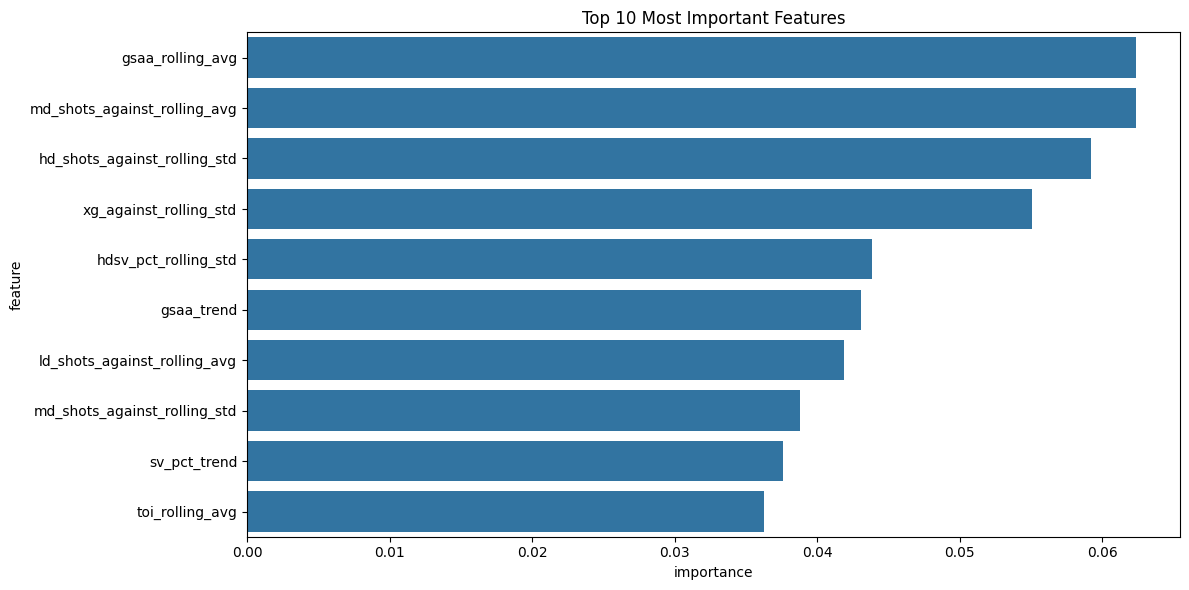

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame({
    'feature': list(metrics['feature_importance'].keys()),
    'importance': list(metrics['feature_importance'].values())
}).sort_values('importance', ascending=False)

sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

Original data length: 21
Predictions length: 21
X_scaled shape: (21, 28)


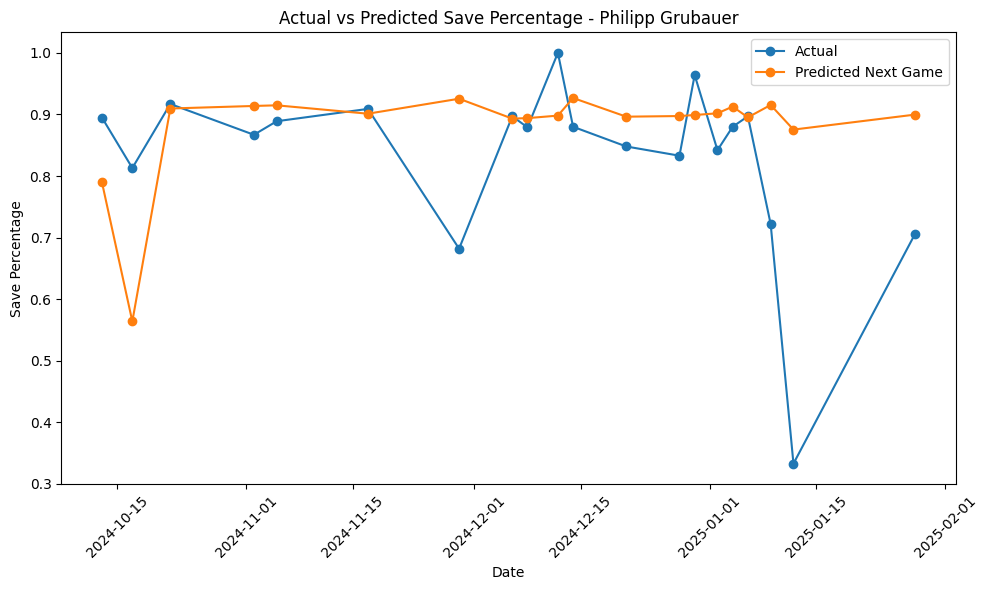


Predicted save percentage for Philipp Grubauer's next game: 0.837


In [ ]:
# Plot actual vs predicted values for a specific goalie
goalie_name = 'Philipp Grubauer'
goalie_data = processed_data[processed_data['player'] == goalie_name].copy()  # Make a copy
X, processed_df = prepare_features(goalie_data)
X_scaled = scaler.transform(X)
predictions = model.predict(X_scaled)

# Print dimensions to debug
print(f"Original data length: {len(goalie_data)}")
print(f"Predictions length: {len(predictions)}")
print(f"X_scaled shape: {X_scaled.shape}")

# Create the plot with aligned data
plt.figure(figsize=(10, 6))
# Use the same date range for both actual and predicted values
dates = goalie_data['date'].iloc[:-1]  # Remove last date
actual_values = goalie_data['sv_pct'].iloc[:-1]  # Remove last actual value

plt.plot(dates, actual_values, label='Actual', marker='o')
plt.plot(dates, predictions[:-1], label='Predicted Next Game', marker='o')
plt.title(f'Actual vs Predicted Save Percentage - {goalie_name}')
plt.xlabel('Date')
plt.ylabel('Save Percentage')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the prediction for the next game
print(f"\nPredicted save percentage for {goalie_name}'s next game: {predictions[-1]:.3f}")

In [46]:
performance_scalar

1.0187401996962557

In [47]:
g

NameError: name 'g' is not defined